# 날씨예측 (시계열데이터)

# Import Library

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset / Preprocessing
- https://www.kaggle.com/datasets/thedevastator/weather-prediction

도시_temp_mean column을 target으로 설정  
target에 대해서는 normalization 하지 않음

In [2]:
pd_data = pd.read_csv(r"C:\Users\GC\Documents\weather\weather_prediction_dataset.csv")
pd_data = pd_data.drop(columns=['DATE','MONTH'])

# 전처리
normalization_df = (pd_data - pd_data.mean())/pd_data.std()

pd_data_Y = pd.DataFrame()
pd_data_X = normalization_df
for i in pd_data.columns:
    if 'temp_mean' in i:
        pd_data_Y[i] = pd_data[i]
        pd_data_X[i] = pd_data[i]

In [6]:
temperature = np.zeros((len(pd_data),len(pd_data_Y.columns)))
raw_data = np.zeros((len(pd_data), len(pd_data.columns)))
for i in range(len(pd_data)):
    temperature[i] = pd_data_Y.iloc[i].values
    raw_data[i,:] = pd_data_X.iloc[i].values

# EDA(Exploratory Data Analysis)

In [3]:
pd_data.head(3)

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BUDAPEST_cloud_cover,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,3.9,3,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,4.8,8,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,4.8,6,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6


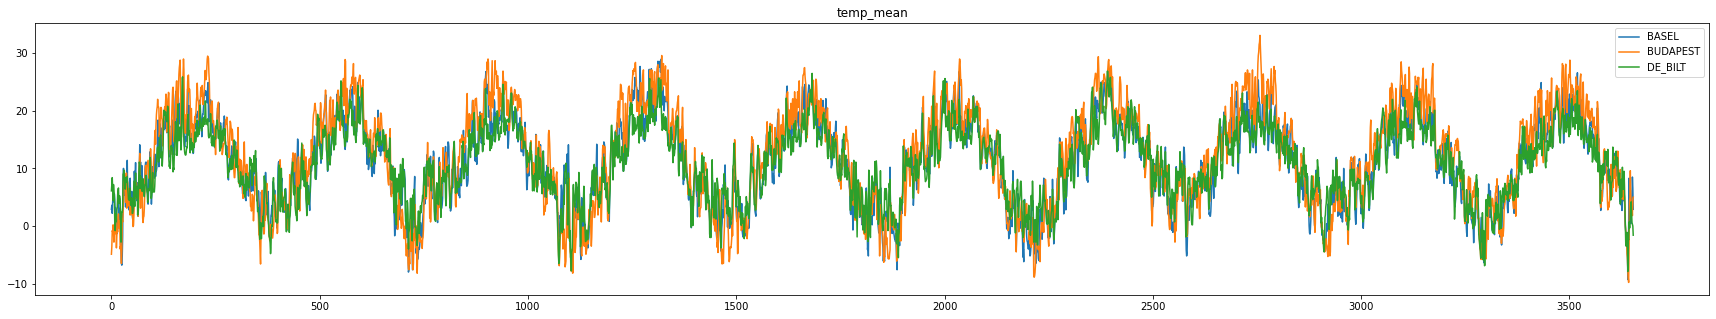

In [ ]:
plt.figure(figsize=(30,5))
plt.title('temp_mean')
plt.plot(range(0, len(temperature[:,0])), temperature[:,0], label='BASEL')
plt.plot(range(0, len(temperature[:,0])), temperature[:,1], label='BUDAPEST')
plt.plot(range(0, len(temperature[:,0])), temperature[:,2], label='DE_BILT')
plt.legend()
plt.show()

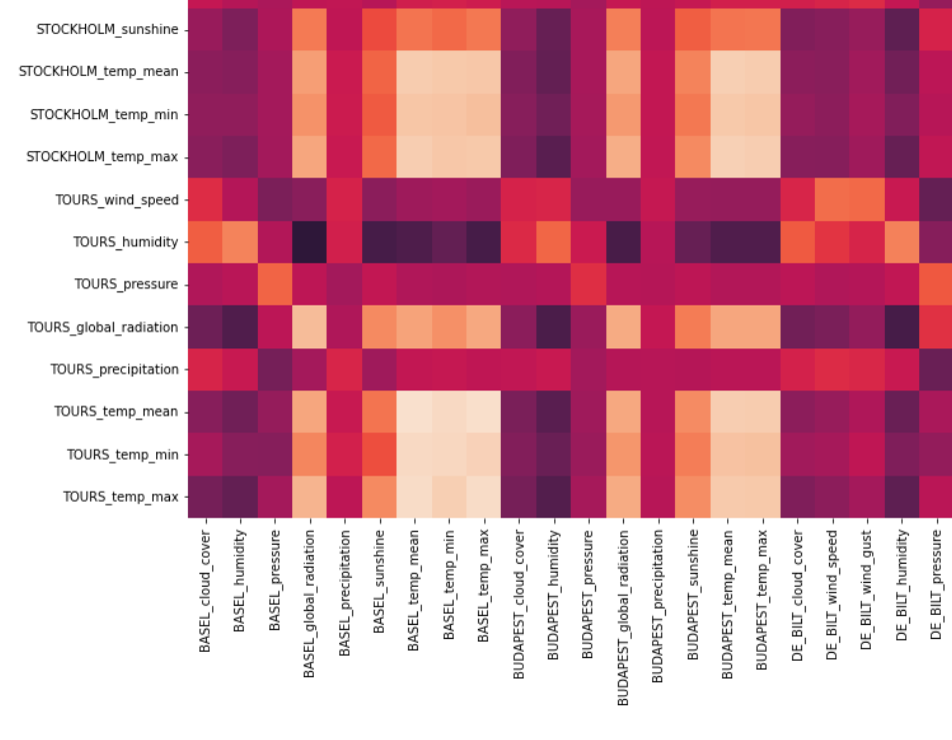

<AxesSubplot:>

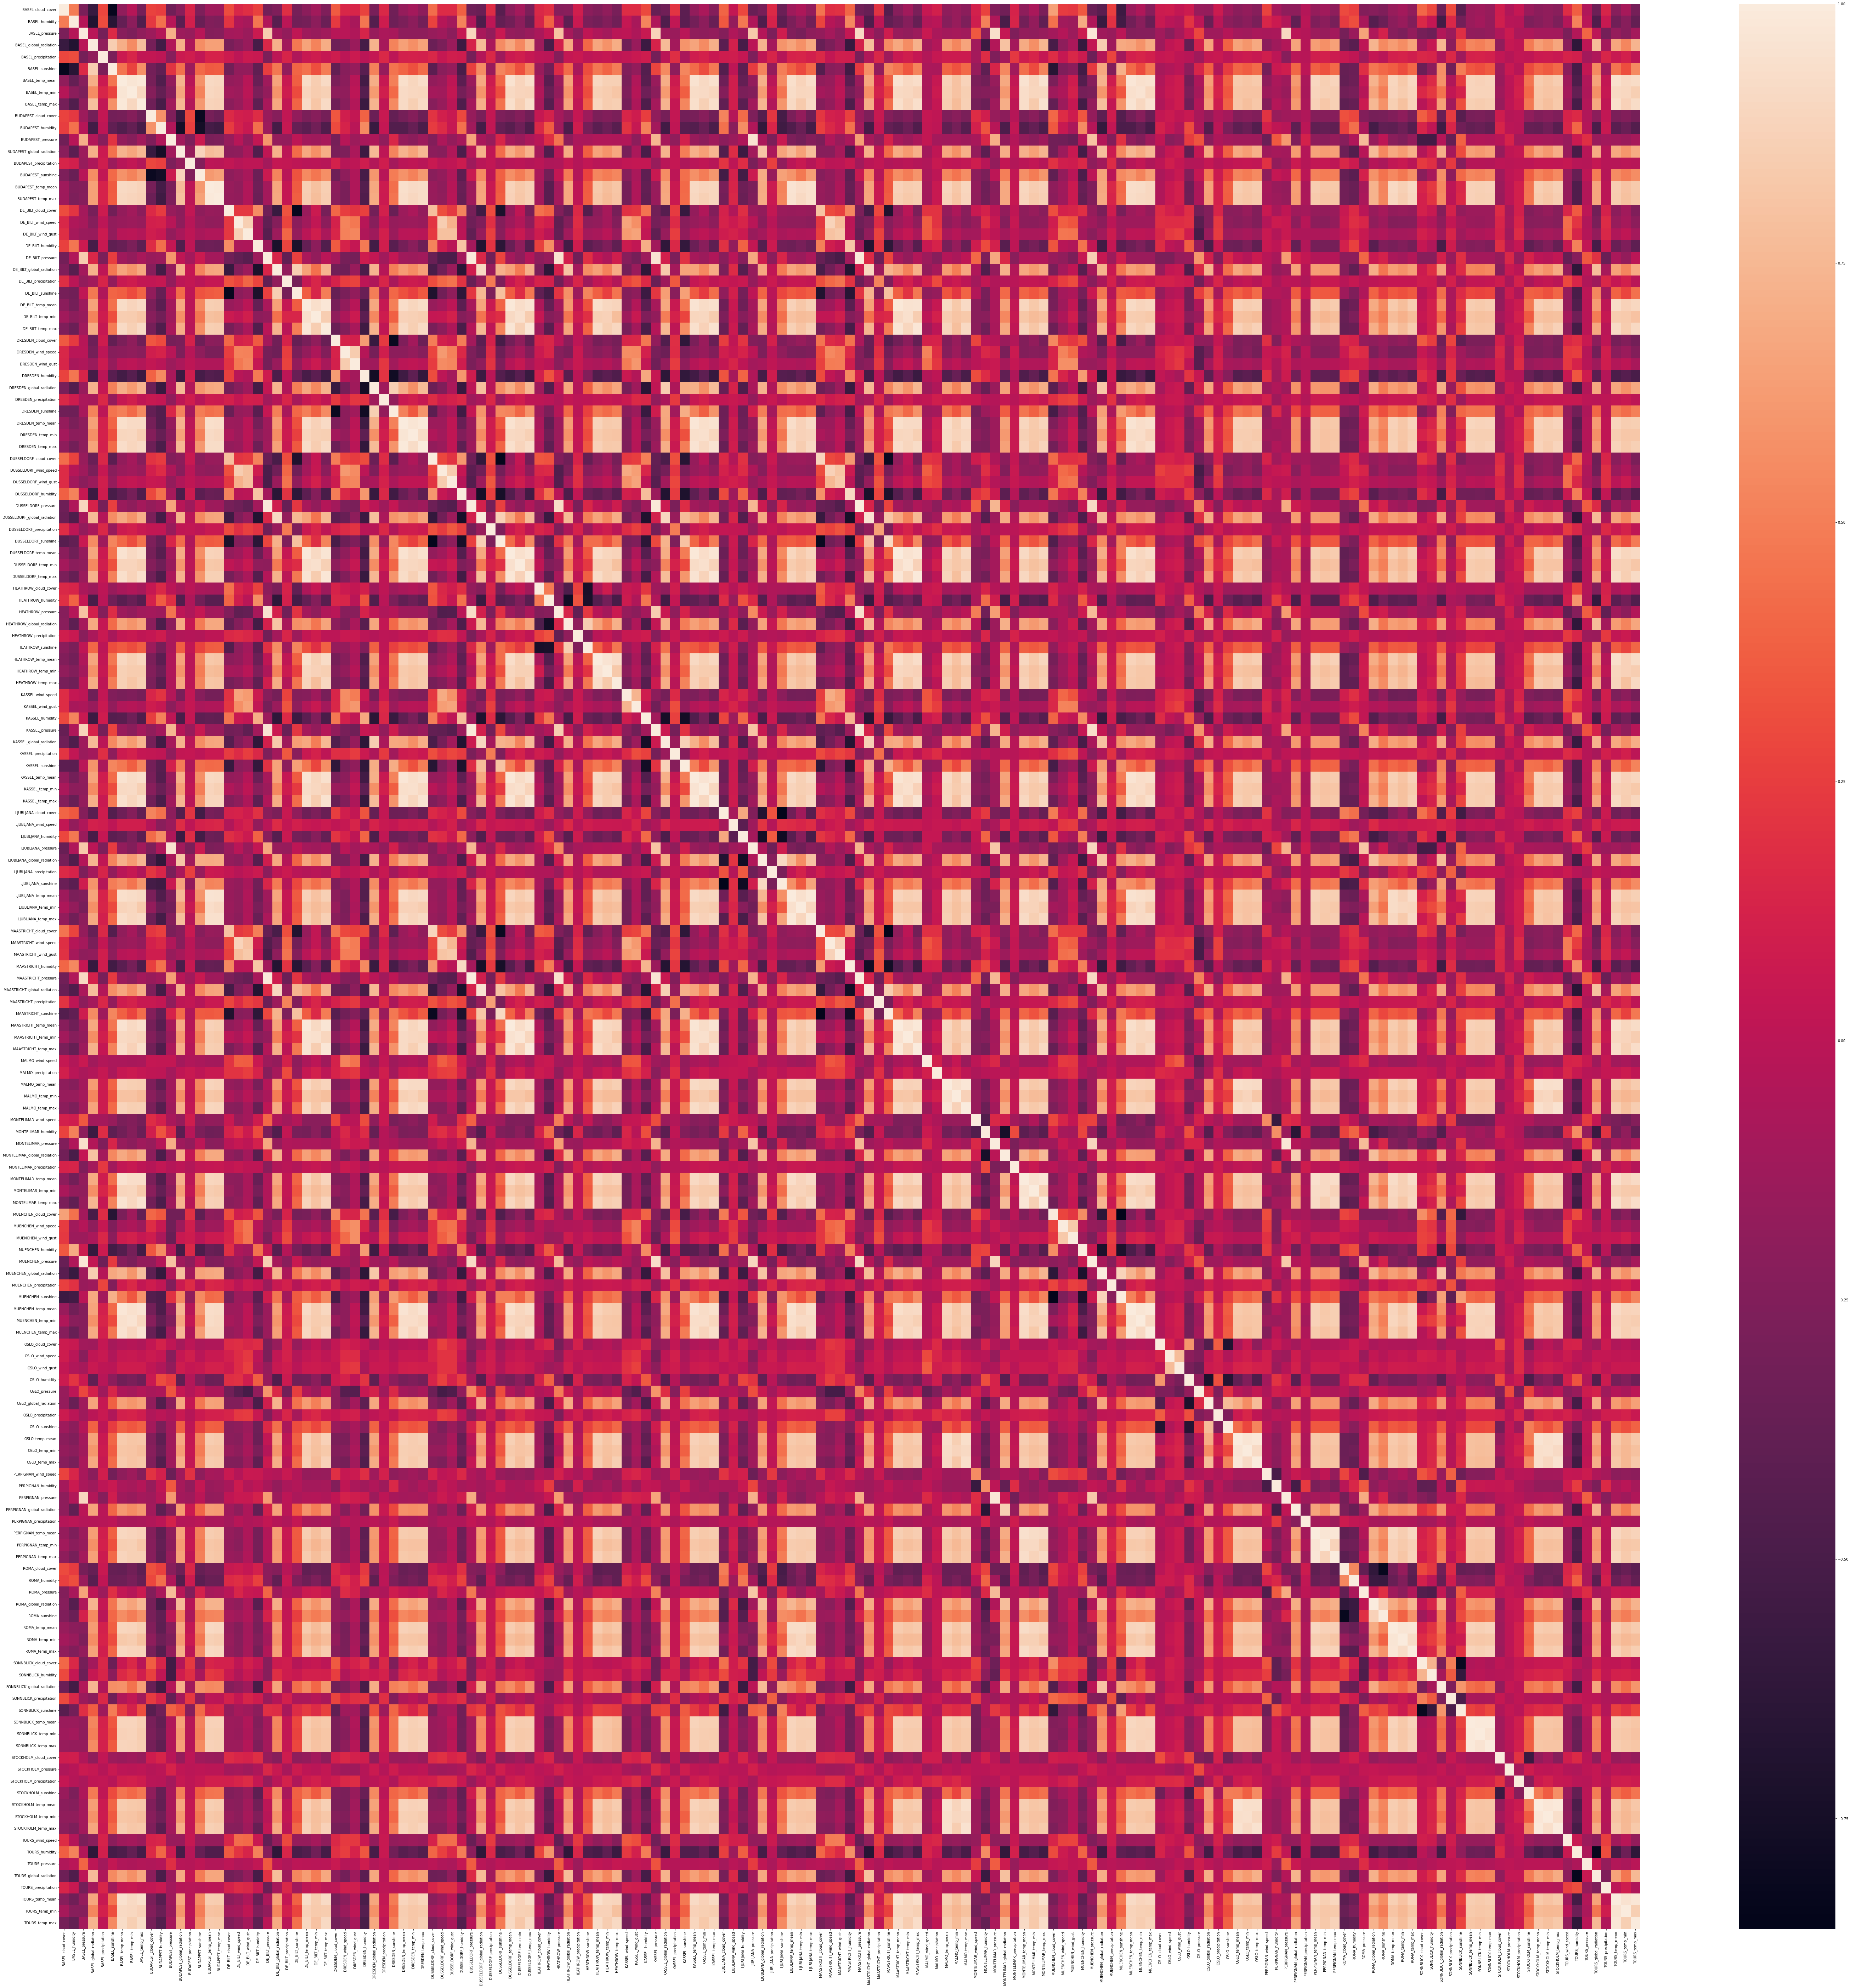

In [7]:
plt.figure(figsize=(100,100))
sns.heatmap(pd_data.corr())

# Create tf.dataset

sequence_length를 20으로 설정하여 20일치의 날씨 정보들을 보고 다음 날의 온도를 예측하고자 함  
5나 10 등으로도 시도해보았으나 20으로 설정하였을 때 경험적으로 가장 좋은 성능을 보임
    
* 2007년까지는 train dataset  
* 2008년까지는 validation dataset  
* 2009년까지는 test dataset

In [4]:
sampling_rate = 1
sequence_length = 20
delay = 20
batch_size = 512

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=2923)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=2923-sequence_length,
    end_index=3289-2*sequence_length)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-1],
    targets=temperature[sequence_length:],
    sampling_rate=1,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=3289-sequence_length)

# Model

GRU 모델을 사용하였고 도시가 총 18개이므로 출력 레이어의 유닛을 18로 설정

In [5]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
gru = layers.GRU(163,recurrent_dropout=0.2, return_sequences=True)(inputs) # 학습에 사용되는 data column수가 163
gru2 = layers.GRU(163)(gru)
#att = layers.Attention()([gru,gru2])
x = layers.Dropout(0.5)(gru2)
outputs = layers.Dense(18)(x)
model = keras.Model(inputs, outputs)
print(model.summary())

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout2.keras",
                                    save_best_only=True)
]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 163)]         0         
_________________________________________________________________
gru (GRU)                    (None, 20, 163)           160392    
_________________________________________________________________
gru_1 (GRU)                  (None, 163)               160392    
_________________________________________________________________
dropout (Dropout)            (None, 163)               0         
_________________________________________________________________
dense (Dense)                (None, 18)                2952      
Total params: 323,736
Trainable params: 323,736
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=1500,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
model.evaluate(test_dataset)

Epoch 1/1500
6/6 [==============================] - 9s 386ms/step - loss: 136.6048 - mae: 9.7388 - val_loss: 101.1914 - val_mae: 8.3484
Epoch 2/1500
6/6 [==============================] - 1s 200ms/step - loss: 92.5214 - mae: 7.7593 - val_loss: 80.9957 - val_mae: 7.3085
Epoch 3/1500
6/6 [==============================] - 1s 197ms/step - loss: 76.3650 - mae: 6.9429 - val_loss: 67.3307 - val_mae: 6.5268
Epoch 4/1500
6/6 [==============================] - 1s 191ms/step - loss: 64.7698 - mae: 6.3075 - val_loss: 57.1218 - val_mae: 5.9293
Epoch 5/1500
6/6 [==============================] - 1s 196ms/step - loss: 55.9730 - mae: 5.8128 - val_loss: 48.5998 - val_mae: 5.3892
Epoch 6/1500
6/6 [==============================] - 1s 195ms/step - loss: 48.5395 - mae: 5.3632 - val_loss: 41.3217 - val_mae: 4.9076
Epoch 7/1500
6/6 [==============================] - 1s 190ms/step - loss: 41.8579 - mae: 4.9388 - val_loss: 35.1034 - val_mae: 4.4803
Epoch 8/1500
6/6 [==============================] - 1s 183ms

[2.9588499069213867, 1.3177679777145386]

# Learning graph plot

### MAE

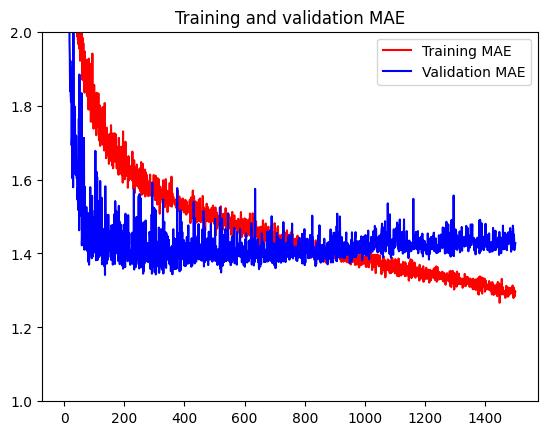

In [9]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.ylim(1,2)
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Loss

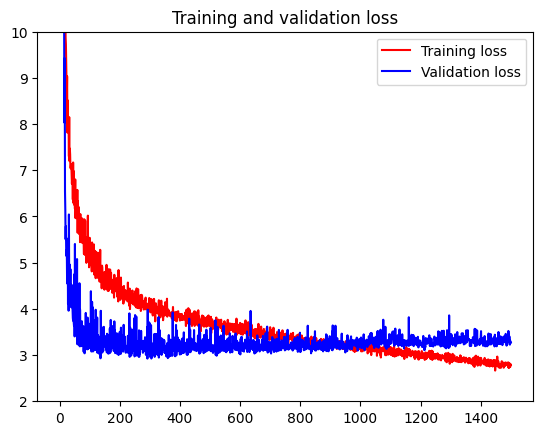

In [16]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.ylim(2,10)
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Inference and Visualize

In [24]:
model.evaluate(test_dataset)

1/1 [==============================] - 1s 851ms/step - loss: 2.9959 - mae: 1.3310


[2.9958701133728027, 1.3309712409973145]

In [6]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
predicted = model.predict(test_dataset)

2009년 1/1 ~ 12/31까지 18개의 도시에 대해 각각 실제 온도와 예측 온도를 비교 plot

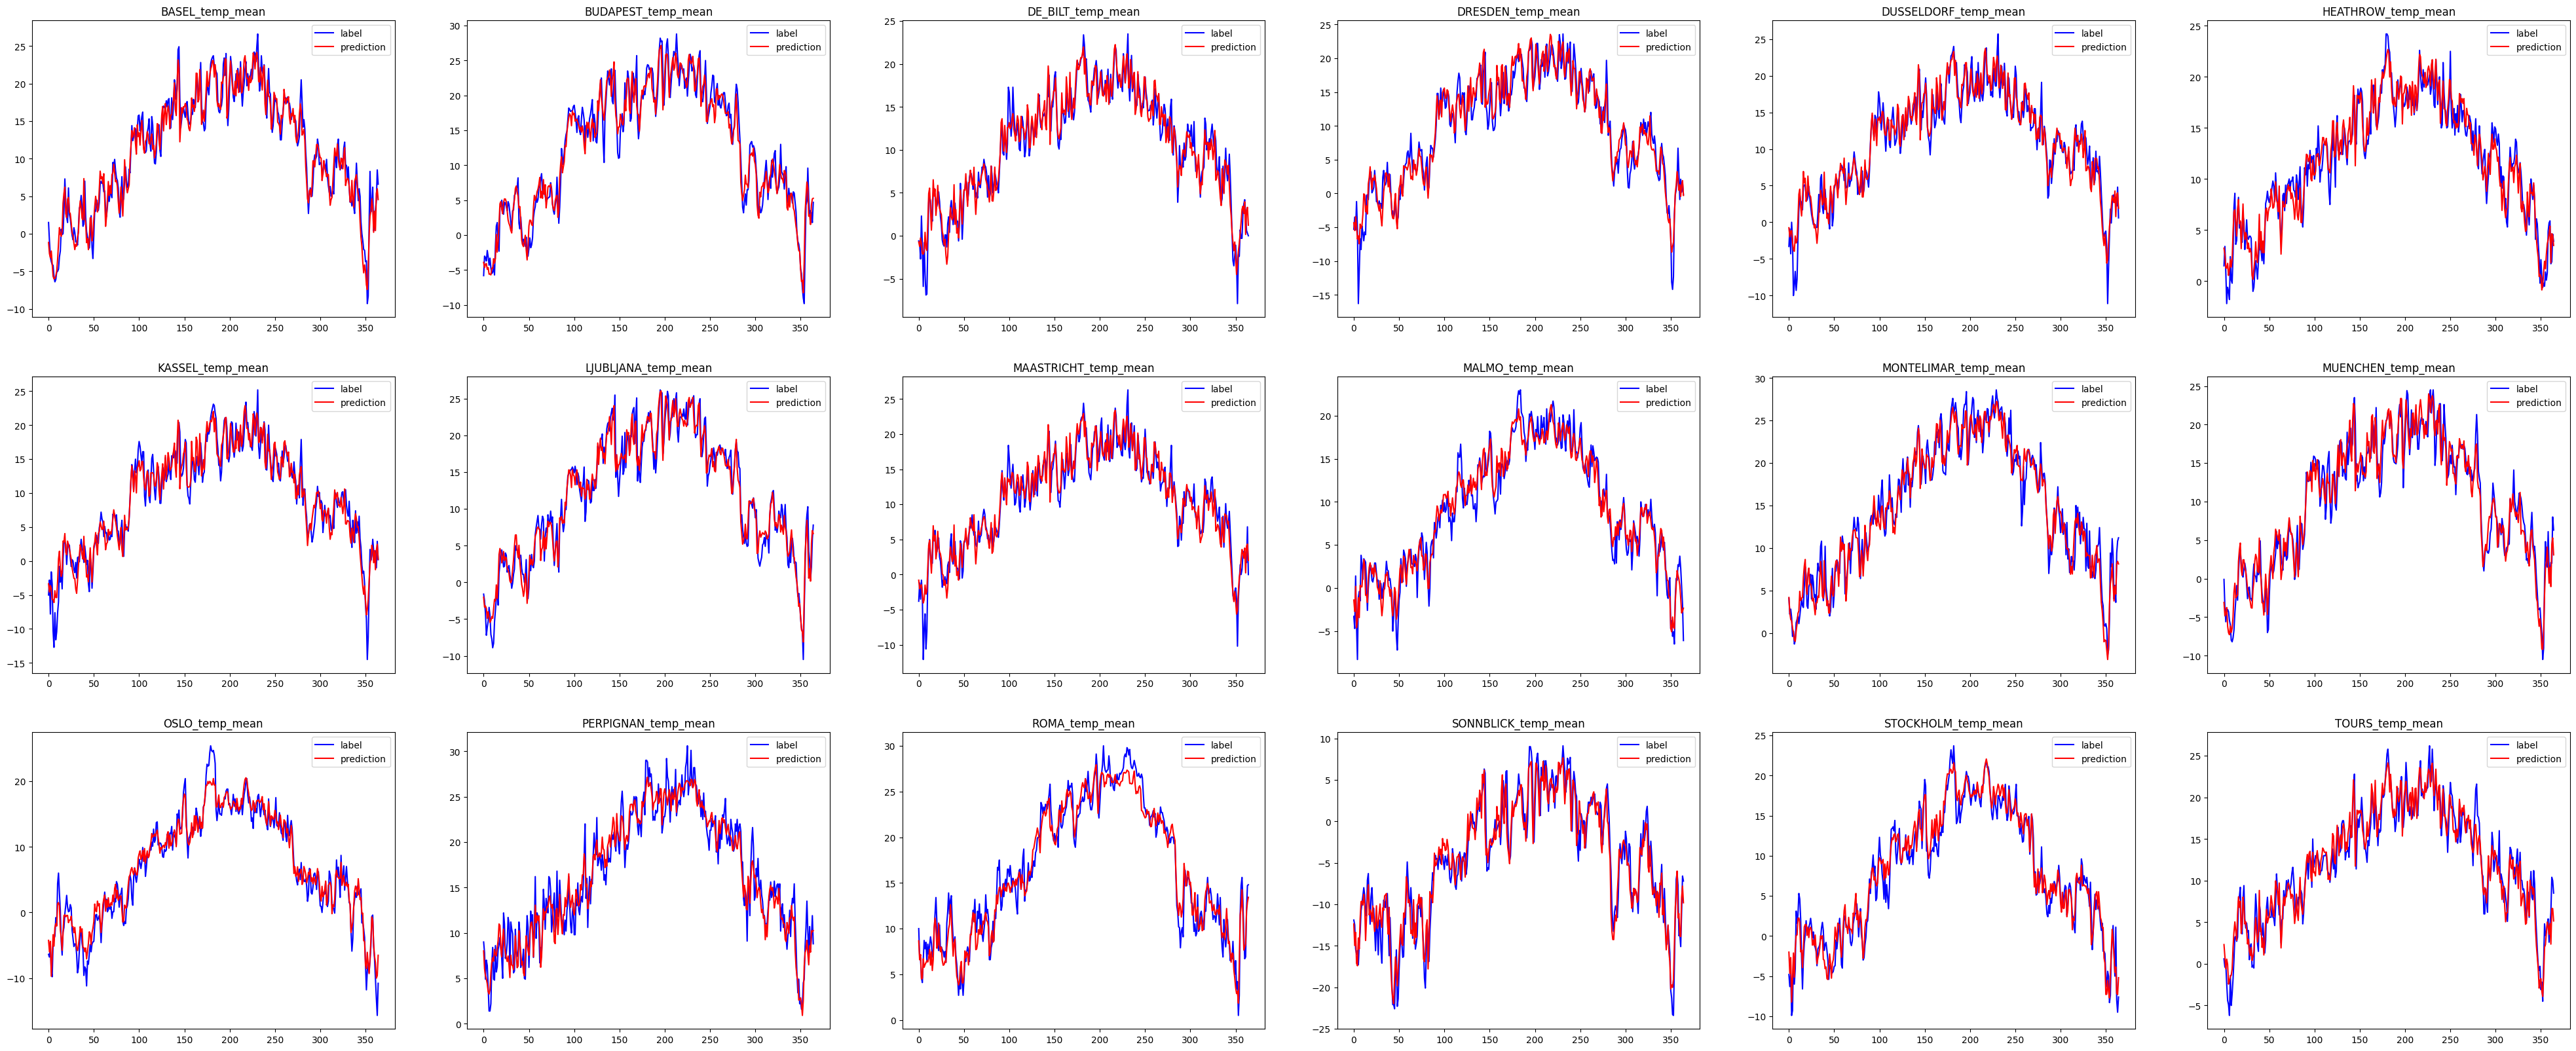

In [9]:
ss =[]
for i in pd_data.columns:
    if 'temp_mean' in i:
        ss.append(i)
fig = plt.figure(figsize=(50,20))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.title(ss[i])
    plt.plot(range(0, len(predicted)), temperature[-366:-1,i],'b', label='label')
    plt.plot(range(0, len(predicted)), predicted[:,i], 'r',label='prediction')
    
    plt.legend()
plt.show()